<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [ ]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy --quiet
#!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

     |████████████████████████████████| 342 kB 5.3 MB/s 


In [ ]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [ ]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

INFO:stanza:Downloading default packages for language: es (Spanish)...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [ ]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [ ]:
text = "personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los murcielagos'

In [ ]:
# Ejemplo de como fuciona
text = "hola personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
tokes = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokes)
print("Lematización de cada token:")
for token in tokes:
    print([token, token.lemma_, token.is_stop])

tokens: hola personas ideas estas cosas y los peces y los murcielagos
Lematización de cada token:
[hola, 'holar', False]
[personas, 'persona', False]
[ideas, 'idea', False]
[estas, 'este', True]
[cosas, 'cosa', False]
[y, 'y', True]
[los, 'el', True]
[peces, 'pez', False]
[y, 'y', True]
[los, 'el', True]
[murcielagos, 'murcielago', False]


### 3 - Diccionario de entrada

In [ ]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola","¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola!", "Hola, ¿Cómo estás?"]
             },
             {"tag": "bienvenida1",
              "patterns": ["Buen dia","Hola, buen dia"],
              "responses": ["Hola, buen dia!", "Buen dia, ¿Cómo estás?"]
             },
             {"tag": "bienvenida2",
              "patterns": ["Buenas tardes","Hola, buenas tardes"],
              "responses": ["Hola, buen buenas tardes!", "Buenas tardes, ¿Cómo estás?"]
             },
             {"tag": "producto",
              "patterns": ["Necesito fabricar palieres", "¿Fabrican palieres?","¿Tienen palieres?", "Necesito un juego de palieres"],
              "responses": ["Si, ¿para que categoria?","Si, para que auto?"]
             },
             {"tag": "producto1",
              "patterns": ["¿Que debo enviar para fabricarlos?", "¿Como debo hacer para encargarlos?"],
              "responses": ["Necesitamos la muestra para poder fabricarlo"]
             },
             {"tag": "plazo",
              "patterns": ["¿Que demora tienen?", "¿Cuanto tardan?", "¿Plazo de entrega?"],
              "responses": ["En material estandar 15 dias, en material PRO 25 dias"]
              },
             {"tag": "plazo",
              "patterns": ["¿Que debo enviar para fabricarlos?", "¿Como debo hacer para encargarlos?"],
              "responses": ["Necesitamos la muestra para poder fabricarlo"]
             },
            {"tag": "categoria",
              "patterns": ["TC","TC2000","Turismo nacional","Top race","Picadas", "Turismo pista","Zonal"],
              "responses": ["ok, algunos modelos los tenemos en stock, otros los fabricamos segun muestra"]
             },
             {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp"],
              "responses": ["Podes contactarnos al telefono 000-0000000", "Contactos al whatsapp 000-0000000"]
             },
            {"tag": "precios",
              "patterns": ["precio", "Me podrás pasar los precios", "¿Cuánto vale?", "¿Cuánto sale?"],
              "responses": ["En el siguiente link podrás encontrar los precios de todos nuestros productos en stock"]
             },
            {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas"],
              "responses": ["A traves de transferencia bancaria"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [ ]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:
          if token.is_stop == False:         
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

/usr/local/lib/python3.7/dist-packages/stanza/models/common/beam.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords


In [ ]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['chau', 'contacto', 'credito', 'cuota', 'deber', 'demora', 'encargar', 'entrega', 'enviar', 'fabricar', 'gracias', 'holar', 'juego', 'medio', 'nacional', 'necesitar', 'numero', 'pago', 'palier', 'pasar', 'picada', 'pista', 'plazo', 'poder', 'precio', 'race', 'salir', 'tardar', 'tarde', 'tarjeta', 'tc', 'telefono', 'top', 'turismo', 'valer', 'whatsapp', 'zonal']
classes: ['agradecimientos', 'bienvenida', 'bienvenida1', 'bienvenida2', 'categoria', 'contacto', 'despedida', 'pagos', 'plazo', 'precios', 'producto', 'producto1']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', 'Buen dia', 'Hola, buen dia', 'Buenas tardes', 'Hola, buenas tardes', 'Necesito fabricar palieres', '¿Fabrican palieres?', '¿Tienen palieres?', 'Necesito un juego de palieres', '¿Que debo enviar para fabricarlos?', '¿Como debo hacer para encargarlos?', '¿Que demora tienen?', '¿Cuanto tardan?', '¿Plazo de entrega?', '¿Que debo enviar para fabricarlos?', '¿Como debo hacer para encargarlos?', 'TC', 'TC2000', 'Turismo 

In [ ]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 37


In [ ]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 12


In [ ]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):

    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))

    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)

    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### 5 - Entrenamiento del modelo

In [ ]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (37,) output: 12


In [ ]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4864      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 12)                780       
                                                                 
Total params: 13,900
Trainable params: 13,900
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 9ms/step - loss: 2.4823 - accuracy: 0.1429
Epoch 2/200
2/2 [==============================] - 0s 9ms/step - loss: 2.4578 - accuracy: 0.1429
Epoch 3/200
2/2 [==============================] - 0s 8ms/step - loss: 2.4066 - accuracy: 0.1667
Epoch 4/200
2/2 [==============================] - 0s 8ms/step - loss: 2.4111 - accuracy: 0.1429
Epoch 5/200
2/2 [==============================] - 0s 8ms/step - loss: 2.4225 - accuracy: 0.2143
Epoch 6/200
2/2 [==============================] - 0s 7ms/step - loss: 2.4099 - accuracy: 0.2381
Epoch 7/200
2/2 [==============================] - 0s 6ms/step - loss: 2.3753 - accuracy: 0.1429
Epoch 8/200
2/2 [==============================] - 0s 6ms/step - loss: 2.3776 - accuracy: 0.1667
Epoch 9/200
2/2 [==============================] - 0s 7ms/step - loss: 2.3909 - accuracy: 0.2143
Epoch 10/200
2/2 [==============================] - 0s 8ms/step - loss: 2.3399 - accuracy: 0.1905
Epoch 11/200
2/2 [===========

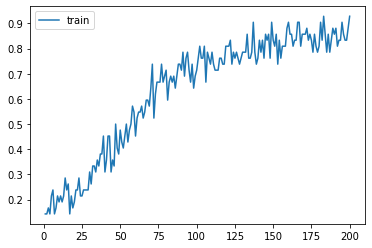

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [ ]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [ ]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [ ]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")
    

Hola, buen dia
Q: Hola, buen dia
1/1 [==============================] - 0s 110ms/step
BOT: Hola, ¿Cómo estás?
estoy averiguando por palieres
Q: estoy averiguando por palieres
1/1 [==============================] - 0s 25ms/step
BOT: Si, ¿para que categoria?
es para un auto de picadas
Q: es para un auto de picadas
1/1 [==============================] - 0s 22ms/step
BOT: ok, algunos modelos los tenemos en stock, otros los fabricamos segun muestra
ok, como debo hacer para encargarlos?
Q: ok, como debo hacer para encargarlos?


/usr/local/lib/python3.7/dist-packages/stanza/models/common/beam.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords


1/1 [==============================] - 0s 20ms/step
BOT: Necesitamos la muestra para poder fabricarlo
ok, plazo?
Q: ok, plazo?
1/1 [==============================] - 0s 17ms/step
BOT: En material estandar 15 dias, en material PRO 25 dias
bien, me podrias pasar el precio?
Q: bien, me podrias pasar el precio?
1/1 [==============================] - 0s 46ms/step
BOT: En el siguiente link podrás encontrar los precios de todos nuestros productos en stock
ok, muchas gracias
Q: ok, muchas gracias
1/1 [==============================] - 0s 21ms/step
BOT: Por nada!, cualquier otra consulta podes escribirme
chau
Q: chau
1/1 [==============================] - 0s 18ms/step
BOT: Hasta luego!


KeyboardInterrupt: ignored

El BOT generado responde de manera acertada las preguntas sobre la venta de un producto, en este caso palieres de autos de competicion.

El hecho de haber quitado las stop word no genero ningun efecto en este caso, el BOT sigue respondiendo de manera acertada.